In [98]:
import pandas as pd
from pyscipopt import Model
import numpy as np
import matplotlib.pyplot as plt

In [99]:
class MOPTAModel:
    def __init__(self, ddir='data'):
        
        # create pyscipopt model
        self.model = Model()

        # read data initially
        self.read_csv(ddir)

        # set count of weeks
        self.n_weeks = 52
        self.max_week_influence = 12

        # accumulate the crew data into easier formats
        # create scip vars if neccessary in the func
        self.add_init_crew()
        self.add_init_qual()
        self.add_leaving_crew()
        self.add_demand()
        self.add_simulator()

        self.calc_training_lengths()
        self.add_training_vars()
        self.calc_training_influence_weeks_simulator()
        self.constraint_training_simulator_availability()
        self.constraint_training_must_finish()

        self.calc_training_influence_weeks_trainer()
        self.add_active_trainer_vars()
        self.constraint_active_trainers()

        self.constraint_training_trainer_availability()
        self.calc_training_regain()
        self.add_regain_vars()

        self.add_student_vars()
        self.constraint_students_by_training()

        self.constraint_regain_by_students()

        self.add_finished_training_student_vars()
        self.constraint_finished_training_student_vars()

        self.add_hiring_vars()
        self.constraint_hiring_by_zero()

        self.add_free_crew_vars()
        self.constraint_free_crew_by_init_left_students_trainer_hiring_finished()
        self.constraint_students_by_free_crew()

        self.add_flight_ready_crew_vars()

        self.add_flight_ready_crew_vars()
        self.constraint_flight_ready_crew_by_free_crew_students_trainer_regain()

        self.add_grounded_vars()
        self.constraint_grounded_by_available()

        self.setOptimizationTarget()

    def optimize(self):
        self.model.redirectOutput()
        self.model.optimize()

    def setOptimizationTarget(self):
        #self.model.setObjective(sum([var for i in [1,2,3,4,5] for var in self.training_vars_weeks[i]]), 'maximize')

        #self.model.setObjective(sum(self.student_vars_week[1]), 'maximize')

        #self.model.setObjective(self.free_crew_vars_week['A']['C'][self.n_weeks -  1] - self.free_crew_vars_week['B']['C'][self.n_weeks -  1], 'maximize')

        #self.model.setObjective(self.flight_ready_crew_week['A']['F'][self.n_weeks - 1], 'maximize')
        #self.model.setObjective(sum(self.active_trainer_vars_week['B'][1]), 'maximize')

        #self.model.setObjective(sum(self.free_crew_vars_week['B']['C']), 'maximize')

        self.model.setObjective(sum(self.grounded_vars_week['A']) + sum(self.grounded_vars_week['B']), 'minimize')

    def read_csv(self, dir):

        self.init_crew_df = pd.read_csv(f'{dir}/Initial Crew.csv')
        self.init_qual_df = pd.read_csv(f'{dir}/Initial Crew Type Qualification.csv')
        self.crew_leaving_df = pd.read_csv(f'{dir}/Crew Leaving.csv').fillna(0)
        self.demand_df = pd.read_csv(f'{dir}/Crew Demand.csv')[['Week', 'Aircraft', 'Demand']]
        self.sim_df = pd.read_csv(f'{dir}/Simulator Availability.csv')

        self.training_structures_df = pd.read_csv(f'{dir}/Training.csv').fillna(0)

        self.EOY_requirement_df = pd.read_csv(f'{dir}/Airbus Crew EOY Requirement.csv')


    def add_init_crew(self):

        # create value structure for the initial crew values
        # access: self.init_crew_vals['B']['F'] is number of initial crews Boeing First Officer
        self.init_crew_vals = {}
        self.init_crew_vals['B'] = {}
        self.init_crew_vals['A'] = {}

        self.init_crew_vals['B']['F'] = self.init_crew_df[self.init_crew_df['Rating'] == 'Boeing FO']['Total'].item()
        self.init_crew_vals['B']['C'] = self.init_crew_df[self.init_crew_df['Rating'] == 'Boeing C']['Total'].item()
        self.init_crew_vals['A']['F'] = self.init_crew_df[self.init_crew_df['Rating'] == 'Airbus FO']['Total'].item()
        self.init_crew_vals['A']['C'] = self.init_crew_df[self.init_crew_df['Rating'] == 'Airbus C']['Total'].item()
        self.init_crew_vals['B']['E'] = self.init_crew_df[self.init_crew_df['Rating'] == 'External Boeing FO']['Total'].item()
        self.init_crew_vals['A']['E'] = self.init_crew_df[self.init_crew_df['Rating'] == 'External Airbus FO']['Total'].item()


    def add_init_qual(self):

        # create value structure for the initial crew qualification values
        # access: self.init_qual_vals['B'][1] is number of initial crews Boeing qualfication 1
        self.init_qual_vals = {'B':{}, 'A':{}}

        self.init_qual_vals['B'][1] = self.init_qual_df[(self.init_qual_df['Rating'] == 'Boeing FO') & (self.init_qual_df['Type'] == 1)]['Number Qualified'].astype(int).item()
        self.init_qual_vals['B'][2] = self.init_qual_df[(self.init_qual_df['Rating'] == 'Boeing C') & (self.init_qual_df['Type'] == 2)]['Number Qualified'].astype(int).item()
        self.init_qual_vals['B'][3] = self.init_qual_df[(self.init_qual_df['Rating'] == 'Boeing C') & (self.init_qual_df['Type'] == 3)]['Number Qualified'].astype(int).item()
        self.init_qual_vals['A'][1] = self.init_qual_df[(self.init_qual_df['Rating'] == 'Airbus FO') & (self.init_qual_df['Type'] == 1)]['Number Qualified'].astype(int).item()
        self.init_qual_vals['A'][2] = self.init_qual_df[(self.init_qual_df['Rating'] == 'Airbus C') & (self.init_qual_df['Type'] == 2)]['Number Qualified'].astype(int).item()
        self.init_qual_vals['A'][3] = self.init_qual_df[(self.init_qual_df['Rating'] == 'Airbus C') & (self.init_qual_df['Type'] == 3)]['Number Qualified'].astype(int).item()


    def add_leaving_crew(self):

        cum_leaving = self.crew_leaving_df.cumsum()

        # create value structure for the qualified crew left overall up to a specific week
        # access: self.left['B'][1][10] is number of Boeing First Officer with qual 1 that left until week 10
        self.left_qual_vals_week = {'B':{}, 'A':{}}

        self.left_qual_vals_week['B'][1] = cum_leaving['Boeing FO type 1 qual'].to_numpy()
        self.left_qual_vals_week['B'][2] = cum_leaving['Boeing C type 2 qual'].to_numpy()
        self.left_qual_vals_week['B'][3] = cum_leaving['Boeing C type 3 qual'].to_numpy()

        self.left_qual_vals_week['A'][1] = cum_leaving['Airbus FO type 1 qual'].to_numpy()
        self.left_qual_vals_week['A'][2] = cum_leaving['Airbus C type 2 qual'].to_numpy()
        self.left_qual_vals_week['A'][3] = cum_leaving['Airbus C type 3 qual'].to_numpy()


        self.left_vals_week = {'B':{}, 'A':{}}

        self.left_vals_week['B']['F'] = cum_leaving['Boeing FO no qual'].to_numpy() + cum_leaving['Boeing FO type 1 qual'].to_numpy()
        self.left_vals_week['B']['C'] = cum_leaving['Boeing C no qual'].to_numpy() + cum_leaving['Boeing C type 2 qual'].to_numpy() + cum_leaving['Boeing C type 3 qual'].to_numpy()

        self.left_vals_week['A']['F'] = cum_leaving['Airbus FO no qual'].to_numpy() + cum_leaving['Airbus FO type 1 qual'].to_numpy()
        self.left_vals_week['A']['C'] = cum_leaving['Airbus C no qual'].to_numpy() + cum_leaving['Airbus C type 2 qual'].to_numpy() + cum_leaving['Airbus C type 3 qual'].to_numpy()


    def add_demand(self):

        self.demand_vals_week = {}

        self.demand_vals_week['A'] = self.demand_df[self.demand_df['Aircraft'] == 'Airbus']['Demand'].to_numpy()
        self.demand_vals_week['B'] = self.demand_df[self.demand_df['Aircraft'] == 'Boeing']['Demand'].to_numpy()


    def add_simulator(self):

        self.sim_vals_week = self.sim_df['Available Simulators'].to_numpy()

    # create variables for each week: how many trainings of type x in week w are started
    def add_training_vars(self):
        
        self.training_vars_weeks = {1:[], 2:[], 3:[], 4:[], 5:[]}

        for week in range(self.n_weeks):
            for t in range(5):
                
                # index shift 
                training = t + 1

                self.training_vars_weeks[training].append(
                    self.model.addVar(vtype='I', name=f'n_train_{training}_{week}', lb=0)
                )

    def calc_training_influence_weeks_simulator(self):

        self.started_training_influences_sim = {}

        for t in range(5):
            training = t + 1

            training_data = self.training_structures_df[self.training_structures_df['Training Type'] == training]

            # find week index and shift as 1 indexed
            relevant_weeks = training_data[training_data['Simulator Needed'] > 0]['Week of Training'].to_numpy() - 1
            relevant_sim_cap = training_data[training_data['Simulator Needed'] > 0]['Simulator Needed'].to_numpy()

            self.started_training_influences_sim[training] = {w: sim for (w, sim) in zip(relevant_weeks, relevant_sim_cap)}

    def constraint_training_simulator_availability(self):

        self.sim_used_vars_week = []
        training_simulator_influences = [[] for i in range(self.n_weeks + self.max_week_influence)]

        # accumulate all influences per training per week for every week in terms of simulator requirement
        for week in range(self.n_weeks):
            for t in range(5):
                training = t + 1

                for (w, i) in self.started_training_influences_sim[training].items():
                    training_simulator_influences[week + w].append(i * self.training_vars_weeks[training][week])

        for week in range(self.n_weeks):

            sim_used_week = self.model.addVar(vtype='I', name=f'n_sim_used_{week}', lb=0)
            self.sim_used_vars_week.append(sim_used_week)

            self.model.addCons(sim_used_week == sum(training_simulator_influences[week]))
            self.model.addCons(sim_used_week <= self.sim_vals_week[week])

    def calc_training_lengths(self):

        self.train_lengths = (self.training_structures_df.groupby('Training Type').max()['Week of Training'] - 1).to_dict()


    # assumption a training must conclude before EOY
    def constraint_training_must_finish(self):

        for training_weeks, length in zip(self.training_vars_weeks.values(), self.train_lengths.values()):
            for training in training_weeks[-1:-length:-1]:

                self.model.addCons(training == 0)

    # calculate the relative requirement for trainers of a specific qualification
    def calc_training_influence_weeks_trainer(self):

        # stores the influences per training as a list
        # {1: {np.int64(0): (np.int64(1), np.int64(2)),
        #          np.int64(1): (np.int64(1), np.int64(1)),
        #          ...
        #          np.int64(10): (np.int64(2), np.int64(2))},
        #          2: {np.int64(0): (np.int64(1), np.int64(1)),
        self.started_training_influences_trainer = {}

        for t in range(5):
            training = t + 1

            training_data = self.training_structures_df[self.training_structures_df['Training Type'] == training]

            # find week index and shift as 1 indexed
            relevant_weeks = training_data[training_data['Capacity Needed'] > 0]['Week of Training'].to_numpy() - 1
            relevant_trainer_cap = training_data[training_data['Capacity Needed'] > 0]['Capacity Needed'].to_numpy()
            relevant_trainer_type = training_data[training_data['Capacity Needed'] > 0]['Type'].to_numpy()

            self.started_training_influences_trainer[training] = {w: (ty, cap) for (w, ty, cap) in zip(relevant_weeks, relevant_trainer_type ,relevant_trainer_cap)}

    # the number of trainers that are in use in a specific week of a qualification
    def add_active_trainer_vars(self):

        self.active_trainer_vars_week = {aircraft: {qual: [] for qual in [1, 2, 3]} for aircraft in ['A', 'B']}

        for aircraft in ['A', 'B']:
            for qual_type in [1, 2, 3]:
                for week in range(self.n_weeks):

                    trainers_of_aircraft_type_week = self.model.addVar(vtype='I', name=f'n_active_trainers_{aircraft}_{qual_type}_{week}', lb=0)
                    self.active_trainer_vars_week[aircraft][qual_type].append(trainers_of_aircraft_type_week)

    def constraint_active_trainers(self):

        self.training_influence_week_trainer = {}

        self.training_influence_week_trainer['B'] = {k:[[] for _ in range(self.n_weeks)] for k in [1, 2, 3]}
        self.training_influence_week_trainer['A'] = {k:[[] for _ in range(self.n_weeks)] for k in [1, 2, 3]}

        for t in range(5):
            training = t + 1

            aircraft = 'A' if training in [1, 3, 5] else 'B'


            training_vars = self.training_vars_weeks[training]
            started_training_influences = self.started_training_influences_trainer[training]

            for week in range(self.n_weeks):

                # imagine we start the training in this week, check all influences of the training
                for w, (typ, infl) in started_training_influences.items():
                    
                    # only allow valid weeks within the year
                    if week + w >= self.n_weeks:
                        continue

                    self.training_influence_week_trainer[aircraft][typ][week + w].append(infl * training_vars[week])



        for aircraft in ['A', 'B']:
            for qual_type in [1, 2, 3]:
                for week in range(self.n_weeks):

                    self.model.addCons(self.active_trainer_vars_week[aircraft][qual_type][week] == sum(self.training_influence_week_trainer[aircraft][qual_type][week]))

    # assumption: there will be never too few people in the cateogry of the trainer, so overall number of people will not constraint the trainers
    # could be a TODO
    def constraint_training_trainer_availability(self):

        # built them constraints

        for aircraft in ['A', 'B']:
            for qual_type in [1, 2, 3]:
                for week in range(self.n_weeks):

                    self.model.addCons(
                        self.active_trainer_vars_week[aircraft][qual_type][week] <= self.init_qual_vals[aircraft][qual_type] - self.left_qual_vals_week[aircraft][qual_type][week]
                    )

    def add_hiring_vars(self):
        
        self.hiring_vars_week = {'A': [], 'B':[]}

        for aircraft in ['A', 'B']:
            for week in range(self.n_weeks):

                hiring_var = self.model.addVar(vtype='I', name=f'n_hiring_{aircraft}_{week}', lb=0)
                self.hiring_vars_week[aircraft].append(hiring_var)

    # variable to define number of students for a specific training started in this week
    def add_student_vars(self):
        self.student_vars_week = {i:[] for i in [1,2,3,4,5]}

        for t in range(5):
            training = t + 1
            for week in range(self.n_weeks):

                # create variable
                student_var = self.model.addVar(vtype='I', name=f'n_students_{training}_{week}')
                self.student_vars_week[training].append(student_var)

    # assumption all students are regained if there is regain
    def calc_training_regain(self):

        self.started_training_regain = {}

        for t in range(5):
            training = t + 1

            training_data = self.training_structures_df[self.training_structures_df['Training Type'] == training]

            # find week index and shift as 1 indexed
            relevant_weeks = training_data[training_data['Capacity Gained'] > 0]['Week of Training'].to_numpy() - 1

            self.started_training_regain[training] = relevant_weeks

    # regain, while in training
    # this is seperated from the finished training, as a regained from training cant be used for another training
    def add_regain_vars(self):
        
        self.crew_regain_vars_weeks = {aircraft: {qual:[] for qual in ['F', 'C']} for aircraft in ['A', 'B']}

        for aircraft in ['A','B']:
            for qual in ['F', 'C']:
                for week in range(self.n_weeks):

                    regain_var = self.model.addVar(vtype='I', name=f'n_crew_regain_{aircraft}_{qual}_{week}', lb=0)
                    self.crew_regain_vars_weeks[aircraft][qual].append(regain_var)


    def constraint_regain_by_students(self):

        # go through all trainings and accumulate the student vars to create the regain in a specific week
        training_influences = {aircraft: {qual:[[] for _ in range(self.n_weeks)] for qual in ['F', 'C']} for aircraft in ['A', 'B']}

        for training, s_vars in self.student_vars_week.items():

            # find the target aircraft of the training
            aircraft = 'A' if training in [1, 3, 5] else 'B'

            # find the target qualifiaction of the training
            qual = 'F' if training in [1, 4, 5] else 'C'

            for week, student_var in enumerate(s_vars):

                for w in self.started_training_regain[training]:
                    if week + w >= self.n_weeks:
                        continue
                    training_influences[aircraft][qual][week + w].append(student_var)


        # now we build a constraint on this basis for every week regain
                    
        for aircraft in ['A', 'B']:
            for qual in ['F', 'C']:
                for week in range(self.n_weeks):

                    self.model.addCons(self.crew_regain_vars_weeks[aircraft][qual][week] == sum(training_influences[aircraft][qual][week]))


    # this is the number of trained crews, basically a static regain but this personal can also be retrained again
    # it is how many finish in this week
    def add_finished_training_student_vars(self):
        
        self.finished_training_student_vars_week = {aircraft: {qual:[] for qual in ['F', 'C']} for aircraft in ['A', 'B']}

        for aircraft in ['A', 'B']:
            for qual in ['F', 'C']:
                for week in range(self.n_weeks):

                    finished = self.model.addVar(vtype='I', name=f'n_finished_training_{aircraft}_{qual}_{week}', lb=0)
                    self.finished_training_student_vars_week[aircraft][qual].append(finished)


    def constraint_finished_training_student_vars(self):

        training_influences = {aircraft: {qual:[[] for _ in range(self.n_weeks)] for qual in ['F', 'C']} for aircraft in ['A', 'B']}

        for training, student_vars in self.student_vars_week.items():

            # get the length of this type of training to find out when it finishes
            train_length = self.train_lengths[training]
            aircraft = 'A' if training in [1, 3, 5] else 'B'
            qual = 'F' if training in [1, 4, 5] else 'C'

            # go through weeks
            for week, student_var in enumerate(student_vars):

                # sanity check if the training finishes in time
                if week + train_length >= self.n_weeks:
                    continue

                # add this student var to the pool of influences for the week
                training_influences[aircraft][qual][week + train_length].append(student_var)


        # now again accumulate the student vars into the finished vars

        # for every finished varsw 
        for aircraft in ['A', 'B']:
            for qual in ['F', 'C']:
                for week in range(self.n_weeks):
        
                    self.model.addCons(self.finished_training_student_vars_week[aircraft][qual][week] == sum(training_influences[aircraft][qual][week]))

    # basically n_students <= max_students * num_training
    def constraint_students_by_training(self):

        for t in range(5):
            training = t + 1

            # find max students for the training
            max_students = self.training_structures_df[self.training_structures_df['Training Type'] == training]['Max Students'].to_numpy()[0]

            for week in range(self.n_weeks):

                self.model.addCons(self.student_vars_week[training][week] <= max_students * self.training_vars_weeks[training][week])

    # a preliminary variable that accumulates changes for the calculation of the students and the available crew later on
    # initial - left - students_prev_from_this - active_trainer + hiring
    def add_free_crew_vars(self):
        
        self.free_crew_vars_week = {aircraft: {qual:[] for qual in ['F', 'C', 'E']} for aircraft in ['A', 'B']}

        for aircraft in ['A', 'B']:
            for qual in ['F', 'C', 'E']:
                for week in range(self.n_weeks):

                    free_crew_var = self.model.addVar(vtype='I', name=f'n_free_crew_{aircraft}_{qual}_{week}', lb=0)
                    self.free_crew_vars_week[aircraft][qual].append(free_crew_var)

    # this does not contain the cap regain, as they are not free, they are restricted in their actions as they can only be used in flying a plane
    # assumption: freshly hired first officers will not leave
    def constraint_free_crew_by_init_left_students_trainer_hiring_finished(self):

        for aircraft in ['A', 'B']:
            for qual in ['F', 'C', 'E']:
                
                for week in range(self.n_weeks):

                    # start with the initial value
                    value = self.init_crew_vals[aircraft][qual]

                    # subtract the cumulitive left values, freshly hired ones are assumed they cant leave
                    if qual != 'E':
                        value -= self.left_vals_week[aircraft][qual][week]

                    # subtract the students, that were chosen form this pool
                    # for this go through every trainig that affects aricraft, qual as an input pool
                    relevant_trainings = []

                    if aircraft == 'B' and qual == 'F':
                        relevant_trainings = [1, 2]

                    elif aircraft == 'B' and qual == 'C':
                        relevant_trainings = [3]

                    elif aircraft == 'B' and qual == 'E':
                        relevant_trainings = [4]

                    elif aircraft == 'A' and qual == 'E':
                        relevant_trainings = [5]

                    # accumulate the students together until this week and subtract them
                    for training in relevant_trainings:
                        value -= sum(self.student_vars_week[training][:week])

                    # subtract the active trainers from the pool
                    relevant_type = []

                    if qual == 'F':
                        relevant_type = [1]
                    elif qual == 'C':
                        relevant_type = [2, 3]
                        
                    for t in relevant_type:
                        value -= self.active_trainer_vars_week[aircraft][t][week]

                    # consider the hiring if we look at the external until now
                    if qual == 'E':
                        value += sum(self.hiring_vars_week[aircraft][:week])

                    # add the ones that finished training and are now in our pool 
                    # nobody will finish training to a external
                    if qual != 'E':
                        value += sum(self.finished_training_student_vars_week[aircraft][qual][:week])

                    #print(f'{aircraft} - {qual} - week {week} --- {value}')
                    self.model.addCons(
                        self.free_crew_vars_week[aircraft][qual][week] == value,
                        name=f'cons_free_crew_{aircraft}_{qual}_{week}'
                    )


    def constraint_students_by_free_crew(self):
        
        for t in range(5):
            training = t + 1
            for week in range(self.n_weeks):

                student_pool_aircraft = 'A' if training == 5 else 'B'
                student_pool_qual = 'F'

                if training == 3:
                    student_pool_qual = 'C'

                elif training in [4, 5]:
                    student_pool_qual = 'E'

                self.model.addCons(self.student_vars_week[training][week] <= self.free_crew_vars_week[student_pool_aircraft][student_pool_qual][week])

    
    def add_flight_ready_crew_vars(self):
        self.flight_ready_crew_week = {aircraft: {qual:[] for qual in ['F', 'C', 'E']} for aircraft in ['A', 'B']}

        for aircraft in ['A', 'B']:
            for qual in ['F', 'C', 'E']:

                for week in range(self.n_weeks):

                    flight_ready_var = self.model.addVar(vtype='I', name=f'n_flight_ready_{aircraft}_{qual}_{week}', lb=0)
                    self.flight_ready_crew_week[aircraft][qual].append(flight_ready_var)

    # accumulate all variables into the available crews: initial - left - students(from this to another) - active_trainer + hiring + students(from another to this)
    def constraint_flight_ready_crew_by_free_crew_students_trainer_regain(self):
        for aircraft in ['A', 'B']:
            for qual in ['F', 'C', 'E']:

                # calculated how many students started their training in this week, as they are not available for flying anymore
                selected_students = 0
                relevant_trainings = []
                if aircraft == 'B' and qual == 'F':
                    relevant_trainings = [1, 2]

                elif aircraft == 'B' and qual == 'C':
                    relevant_trainings = [3]

                elif aircraft == 'B' and qual == 'E':
                    relevant_trainings = [4]

                elif aircraft == 'A' and qual == 'E':
                    relevant_trainings = [5]

                relevant_type = []

                if qual == 'F':
                    relevant_type = [1]
                elif qual == 'C':
                    relevant_type = [2, 3]


                for week in range(self.n_weeks):

                    # start with the free crews
                    flight_ready = self.free_crew_vars_week[aircraft][qual][week]

                    # subtract the students we selected this week for training
                    # accumulate the students together until this week and subtract them
                    for training in relevant_trainings:
                        selected_students += self.student_vars_week[training][week]
                    flight_ready -= selected_students

                    # subtract the active trainers of this week
                    selected_trainer = 0
                    for t in relevant_type:
                        selected_trainer += self.active_trainer_vars_week[aircraft][t][week]
                    flight_ready -= selected_trainer

                    # add the regain
                    # only if not extern
                    if qual != 'E':
                        flight_ready += self.crew_regain_vars_weeks[aircraft][qual][week]

                    # add the constraint
                    self.model.addCons(self.flight_ready_crew_week[aircraft][qual][week] ==  flight_ready )


    def add_grounded_vars(self):
        
        self.grounded_vars_week = {aircraft: [] for aircraft in ['A', 'B']}

        for aircraft in ['A', 'B']:
            for week in range(self.n_weeks):

                g_var = self.model.addVar(vtype='I', name=f'n_grounded_{aircraft}_{week}', lb=0)
                self.grounded_vars_week[aircraft].append(g_var)

    def constraint_grounded_by_available(self):
        
        for aircraft in ['A', 'B']:
            for week in range(self.n_weeks):

                for qual in ['F', 'C']:
                    self.model.addCons(self.grounded_vars_week[aircraft][week] >= self.demand_vals_week[aircraft][week] - self.flight_ready_crew_week[aircraft][qual][week])

    def add_EOY_requirement(self):
        pass

    def constraint_available_crew_by_EOY(self):
        pass

    # grounded + hiring costs
    def add_cost_var(self):
        pass

    # optional
    def constraint_crew_by_demand(self):
        pass

    # neccessary 
    def constraint_hiring_by_zero(self):
        
        for aircraft in ['A', 'B']:
            for week in range(self.n_weeks):

                self.model.addCons(self.hiring_vars_week[aircraft][week] <= 2)


    def get_active_trainer_values(self):

        out = {aircraft: {qual: [] for qual in [1, 2, 3]} for aircraft in ['A', 'B']}

        for aircraft in ['A', 'B']:
            for qual in [1, 2, 3]:
                for week in range(self.n_weeks):

                    val = self.model.getVal(self.active_trainer_vars_week[aircraft][qual][week])

                    out[aircraft][qual].append(val)

        return out
    
    def get_free_crew_values(self):

        out = {aircraft: {qual:[] for qual in ['F', 'C', 'E']} for aircraft in ['A', 'B']}

        for aircraft in ['A', 'B']:
            for qual in ['F', 'C', 'E']:
                for week in range(self.n_weeks):

                    val = self.model.getVal(self.free_crew_vars_week[aircraft][qual][week])

                    out[aircraft][qual].append(val)

        return out


In [100]:
optmodel = MOPTAModel()
optmodel.setOptimizationTarget()
optmodel.optimize()

presolving:
(round 1, fast)       1175 del vars, 1352 del conss, 75 add conss, 2560 chg bounds, 6 chg sides, 2 chg coeffs, 0 upgd conss, 23 impls, 21 clqs
(round 2, fast)       1422 del vars, 1572 del conss, 184 add conss, 2631 chg bounds, 171 chg sides, 3 chg coeffs, 0 upgd conss, 24 impls, 21 clqs
(round 3, fast)       1469 del vars, 1612 del conss, 201 add conss, 2658 chg bounds, 196 chg sides, 4 chg coeffs, 0 upgd conss, 24 impls, 21 clqs
(round 4, fast)       1469 del vars, 1635 del conss, 201 add conss, 2658 chg bounds, 229 chg sides, 7 chg coeffs, 0 upgd conss, 24 impls, 21 clqs
(round 5, fast)       1469 del vars, 1635 del conss, 201 add conss, 2743 chg bounds, 229 chg sides, 7 chg coeffs, 0 upgd conss, 24 impls, 21 clqs
(round 6, fast)       1469 del vars, 1635 del conss, 201 add conss, 2743 chg bounds, 230 chg sides, 8 chg coeffs, 0 upgd conss, 24 impls, 21 clqs
(round 7, exhaustive) 1469 del vars, 1790 del conss, 201 add conss, 2743 chg bounds, 345 chg sides, 8 chg coeffs, 0

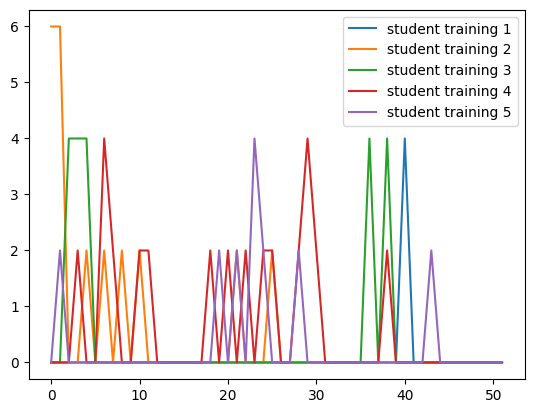

In [101]:
stats_trainer = []

stats_students = [[] for i in range(5)]

for week in range(optmodel.n_weeks):
    stats_trainer.append(optmodel.model.getVal(optmodel.active_trainer_vars_week['B'][1][week]))

    for training in range(5):
        stats_students[training].append(optmodel.model.getVal(optmodel.student_vars_week[training+1][week]))

#plt.plot(stats_trainer, label='maxed trainer')

for training in range(5):
    plt.plot(stats_students[training], label=f'student training {training + 1}')
plt.legend()

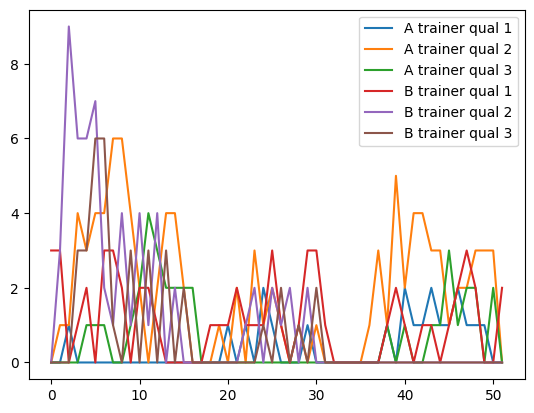

In [102]:
actives = optmodel.get_active_trainer_values()

for aircraft, typ_trainer in actives.items():
    for qual, trains in typ_trainer.items():
        plt.plot(trains, label=f'{aircraft} trainer qual {qual}')

plt.legend()
plt.show()

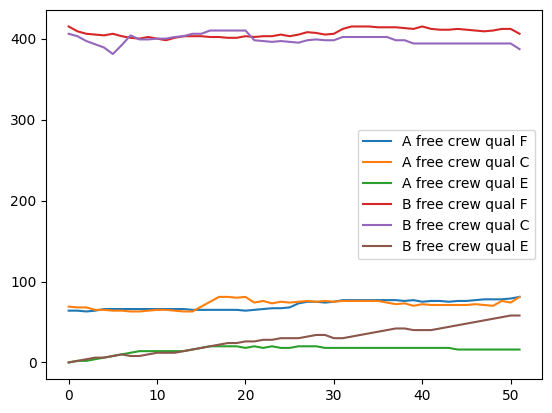

In [103]:
actives = optmodel.get_free_crew_values()

for aircraft, typ_trainer in actives.items():
    for qual, trains in typ_trainer.items():
        plt.plot(trains, label=f'{aircraft} free crew qual {qual}')

plt.legend()
plt.show()